In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [104]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from keras.models import Sequential , Model
from keras.layers import Dense,Flatten,Reshape,Dropout,LeakyReLU,Conv2DTranspose,Conv2D
from keras.optimizers import Adam,SGD
from keras.layers import  LeakyReLU, BatchNormalization, Input

In [105]:
from keras.datasets import mnist
(train_images, y_train), (_, _) = mnist.load_data()                                      # loading mnist data
print(len(train_images))
train_images=train_images[(y_train==0) | (y_train==1) | (y_train==5) | (y_train==7)]     # taking images with labels 1,2,3,4 for demostration purposes only
train_images=train_images[:5000]                                                          # taking only 5000 images

60000


In [106]:
len(train_images)

5000

In [107]:
def plot_images(images):
    fig, axes = plt.subplots(5, 5, figsize=(5, 5))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

    plt.show()


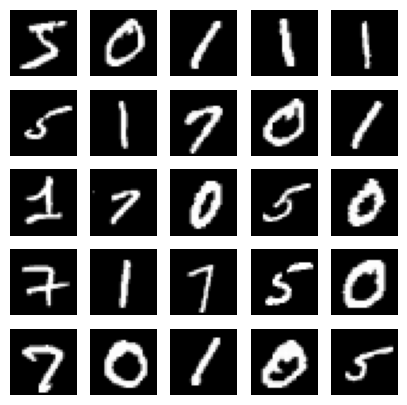

In [108]:
plot_images(train_images)

In [109]:
train_images=train_images.astype("float32")/127.5-1                         # normalising so that values are between -1 & +1
train_images=train_images.reshape(train_images.shape[0],28,28,1)            # now train_images has shape [5000,28,28,1]

In [110]:
def build_generator(latent_dim,input_shape):
    generator=Sequential([

        Dense(7*7*128 , input_dim=latent_dim),
        LeakyReLU(alpha=.2),
        Reshape((7, 7, 128)),
        BatchNormalization(),

        Conv2DTranspose(64 , (4,4) , padding="same" , strides=(2,2)),
        LeakyReLU(alpha=.2),
        BatchNormalization(),

        Conv2DTranspose(32 , (4,4) , padding="same" , strides=(2,2)),
        LeakyReLU(alpha=.2),
        BatchNormalization(),

        Conv2DTranspose(1 , (4,4) , padding="same" , activation="tanh"),


    ])

    return generator

In [111]:
def build_discriminator(input_shape):
    discriminator=Sequential([

        Conv2D(64 , (3,3) , strides=(2,2) , padding="same" , input_shape=input_shape),
        LeakyReLU(alpha=.2),
        Dropout(rate=.4),

        Conv2D(64 , (3,3) , strides=(2,2) , padding="same" , input_shape=input_shape),
        LeakyReLU(alpha=.2),
        Dropout(rate=.4),

        Flatten(),

        Dense(1 , activation="sigmoid" )

     ])
    return discriminator

In [112]:
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during GAN training

    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = Model(gan_input, gan_output)
    return gan

In [113]:
latent_dim=100
image_shape=(28,28,1)

In [114]:
generator = build_generator(latent_dim, image_shape)
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

discriminator = build_discriminator(image_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [115]:
epochs = 200
batch_size = 256

In [116]:
def generate_real_samples(dataset, n_samples):
    idx = np.random.randint(0, train_images.shape[0], n_samples)
    X = train_images[idx]
    y = np.ones((n_samples, 1))
    return X, y

# Generate fake samples using the generator
def generate_fake_samples(generator, latent_dim, n_samples):
    noise = np.random.normal(0, 1, size=(n_samples, latent_dim))
    X = generator.predict(noise)
    y = np.zeros((n_samples, 1))
    return X, y

# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    noise = np.random.normal(0, 1, size=(n_samples, latent_dim))
    return noise

In [117]:
discriminator_loss=[]
gan_loss=[]
generated_list=[]

In [118]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    discriminator_loss=[]
    gan_loss=[]
    generated_list=[]
    # Manually enumerate epochs
    for i in range(n_epochs):
        # Enumerate batches over the training set
        for j in range(bat_per_epo):
            batch_loss_d=[]
            batch_loss_g=[]
            # Get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)

            # Generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            # Create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))

            # Update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            batch_loss_d.append(d_loss)
            # Prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)

            # Create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))

            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            batch_loss_g.append(g_loss)
        gan_los=np.mean(batch_loss_g)
        gan_loss.append(gan_los)
        dis_loss=np.mean(batch_loss_d)
        discriminator_loss.append(dis_loss)

        # Summarize loss on this batch

        if (i + 1) % 10 == 0:
                print(f'Epoch {i + 1}/{n_epochs}, Batch {j + 1}/{bat_per_epo}, D Loss: {d_loss:.3f}, G Loss: {g_loss:.3f}')
        if (i + 1) % 10 == 0:
                num_samples=5
                noise = generate_latent_points(latent_dim, num_samples)
                generated_images = generator.predict(noise)
                generated_list.append(generated_images)

    return discriminator_loss, gan_loss, generated_list

In [ ]:
discriminator_loss, gan_loss, generated_list=train(generator, discriminator, gan, train_images, latent_dim, n_epochs=epochs, n_batch=batch_size)

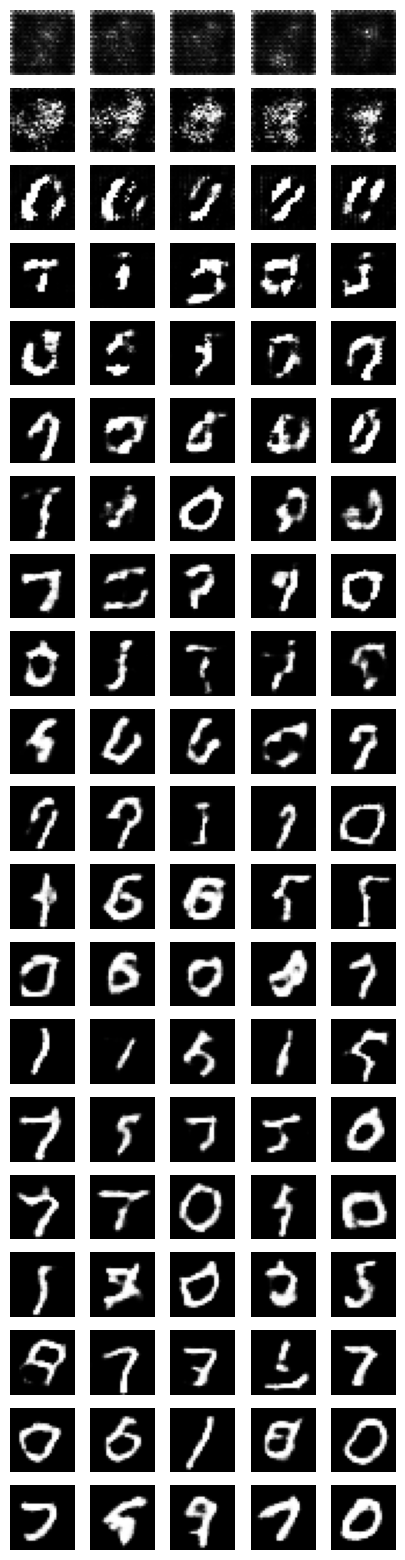

In [101]:
fig, axes = plt.subplots(len(generated_list), 5, figsize=(5, len(generated_list)))
for i in range(len(generated_list)):
    image_list=generated_list[i]
    for j in range(5):
        axes[i,j].imshow(image_list[j],cmap="gray")
        axes[i, j].axis('off')
#plt.tight_layout()
plt.show()

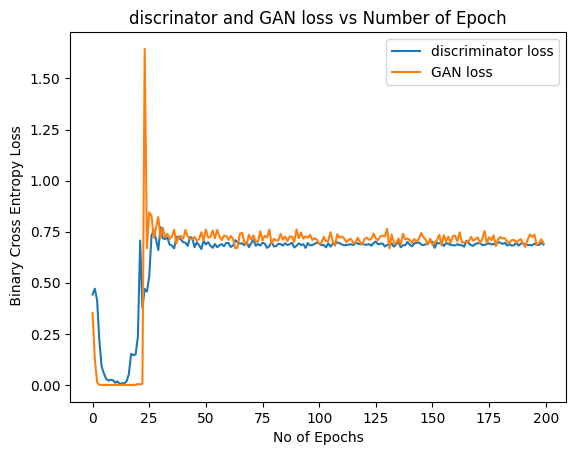

In [102]:
plt.plot(discriminator_loss,label="discriminator loss")
plt.plot(gan_loss,label="GAN loss")
plt.legend()
plt.title("discrinator and GAN loss vs Number of Epoch")
plt.xlabel("No of Epochs")
plt.ylabel(" Binary Cross Entropy Loss")
plt.show()